<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_Inference__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov Model (HMM) State Inference
Implemented the following from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html):

1.   Forward-Backwards algorithm
2.   The Viterbi algorithm



In [1]:
!pip install tqdm -q

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from tqdm import tqdm

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

In [2]:
def normalize(x):
  return x/(tf.reduce_sum(x))

def localEvidence(λ, y):
  return tf.stack([λ[:, y_t, tf.newaxis] for y_t in y])

def Forward(A, a_t, λ, steps):
  a = []
  for i in range(steps):
    a_t = λ[i] * (tf.transpose(A) @ a_t)
    a_t = normalize(a_t)
    a.append(a_t)
  return tf.stack(a)

def Backward(A, a, λ, steps, num_states):
  β_t = tf.fill([num_states, 1], 1.)
  β = [β_t]; g = []

  for i in tqdm(range(steps - 1, 0, -1)):
    g_t = a[i] * β_t
    g_t = normalize(g_t)
    β_t = A @ (λ[i] * β_t)
    β_t = normalize(β_t)
    β.append(β_t)
    g.append(g_t)
  return tf.reverse(tf.stack(β), [0]), tf.reverse(tf.stack(g), [0])

def Viterbi(A, a, λ, steps, num_states):
  δ_t = - tf.math.log(λ[0]) - tf.math.log(a)
  init_state = tf.math.argmin(δ_t)[0]
  λ = - tf.math.log(λ)
  λ = tf.tile(λ, [1, 1, num_states]) 
  A = - tf.math.log(A)
  node = []

  for i in tqdm(range(1, steps)):
    δ_ = A + λ[i] + tf.tile(tf.transpose(δ_t), [num_states, 1])
    min_index = tf.math.argmin(δ_, 1)[:, tf.newaxis]
    δ_t = tf.gather_nd(δ_, min_index, 1)[:, tf.newaxis]
    node.append(min_index)
  state = tf.math.argmin(tf.reshape(δ_, [num_states*num_states]))
  state = tf.cast(state/num_states, tf.int64)
  MAP_path = [state]

  for i in range(steps - 2, 0, -1):
    state = tf.squeeze(node[i][state])
    MAP_path.append(state)
  MAP_path.append(init_state)
  return tf.reverse(tf.stack(MAP_path), [0])

## Casino Dice Roll State Inference

### Generate Sample Data

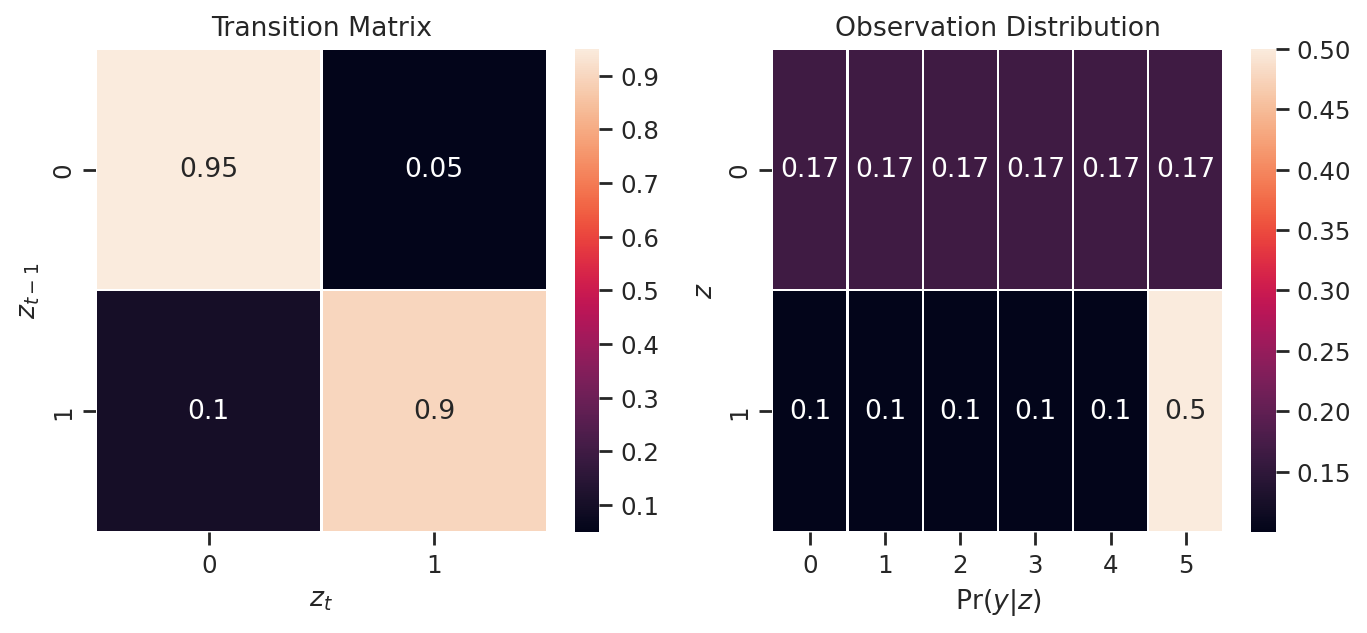

In [3]:
num_states = 2

states_0 = tf.fill([num_states, 1], 1/num_states)
A = tf.constant([
    [0.95, 0.05], (0.1, 0.9)
])

λ = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(A, annot=True, linewidth=.5, ax=axes[0])
sns.heatmap(λ, annot=True, linewidth=.5, ax=axes[1])
axes[0].set(xlabel='$z_{t}$', ylabel='$z_{t-1}$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution')
plt.show()

In [28]:
def CasinoHMM(A, λ, k_0, steps):
  k_t = tfd.Categorical(probs=tf.squeeze(k_0)).sample()
  transition_distribution = tfd.Categorical(probs=A).sample(steps)
  observation_distribution = tfd.Categorical(probs=λ).sample(steps)
  states = []; obs = []
  for i in range(steps):
    k_t = transition_distribution[i, k_t]
    obs_t = observation_distribution[i, k_t]
    obs.append(obs_t)
    states.append(k_t)
  return tf.stack(obs), tf.stack(states)

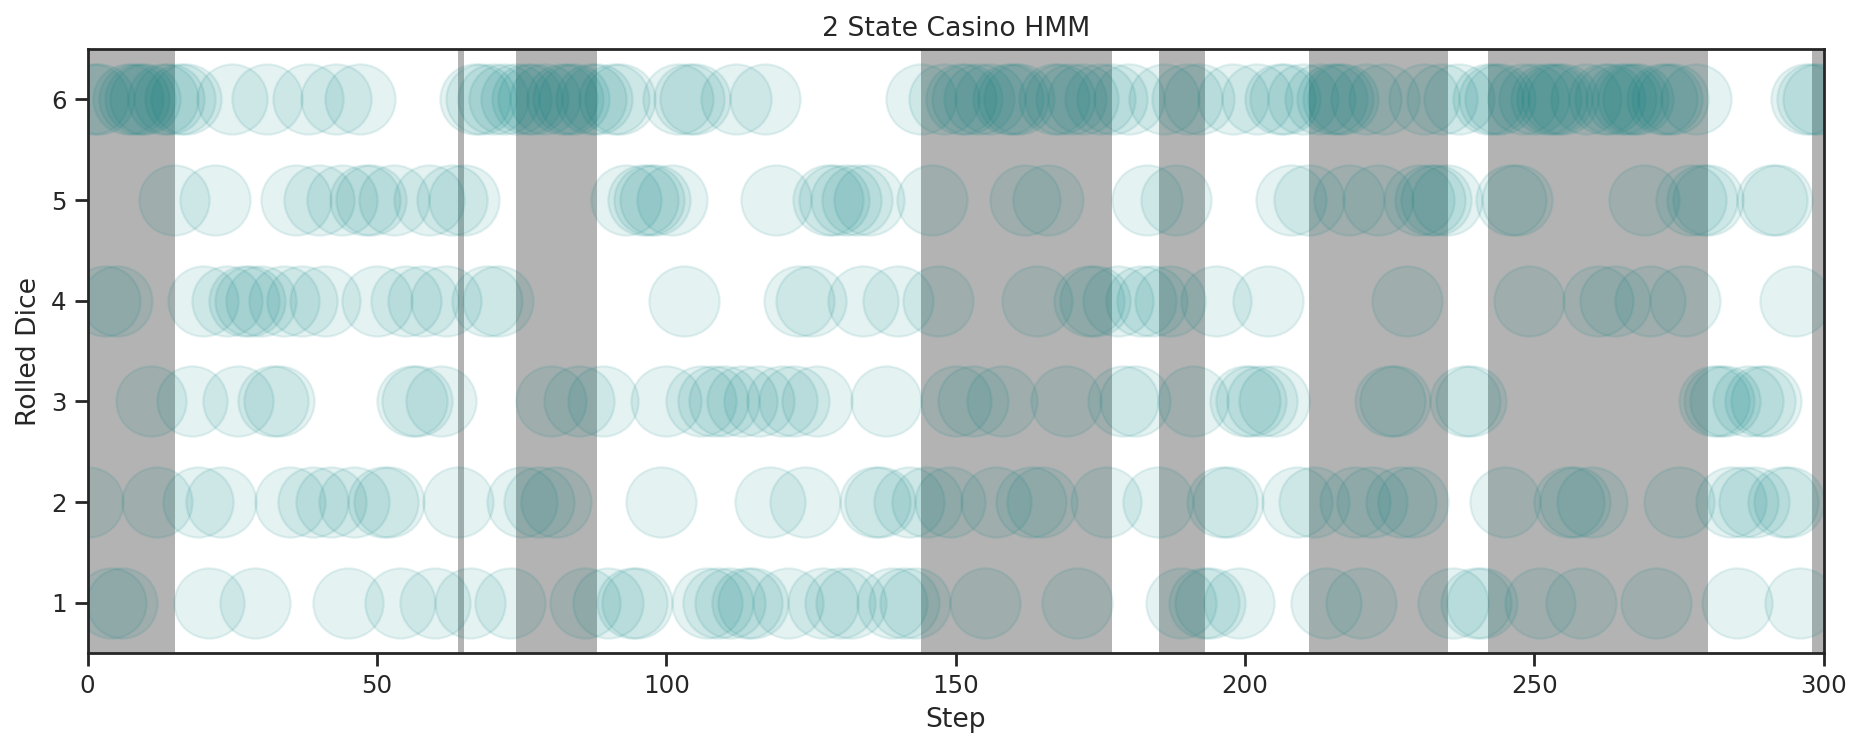

In [29]:
HMM_steps = 300
y, states_true = CasinoHMM(A, λ, states_0, HMM_steps)
plt.figure(figsize=(14, 5))
plt.imshow(
    states_true[None, :], extent=(0, HMM_steps, 0, 7), cmap='Greys', alpha=0.3, aspect='auto'
)
plt.scatter(tf.range(HMM_steps), y + 1, color="teal", alpha=0.1, s=1000)
plt.title("{} State Casino HMM".format(num_states)); plt.ylabel('Rolled Dice');  plt.xlabel('Step'); plt.ylim(0.5, 6.5); plt.show()

### Perform Inference

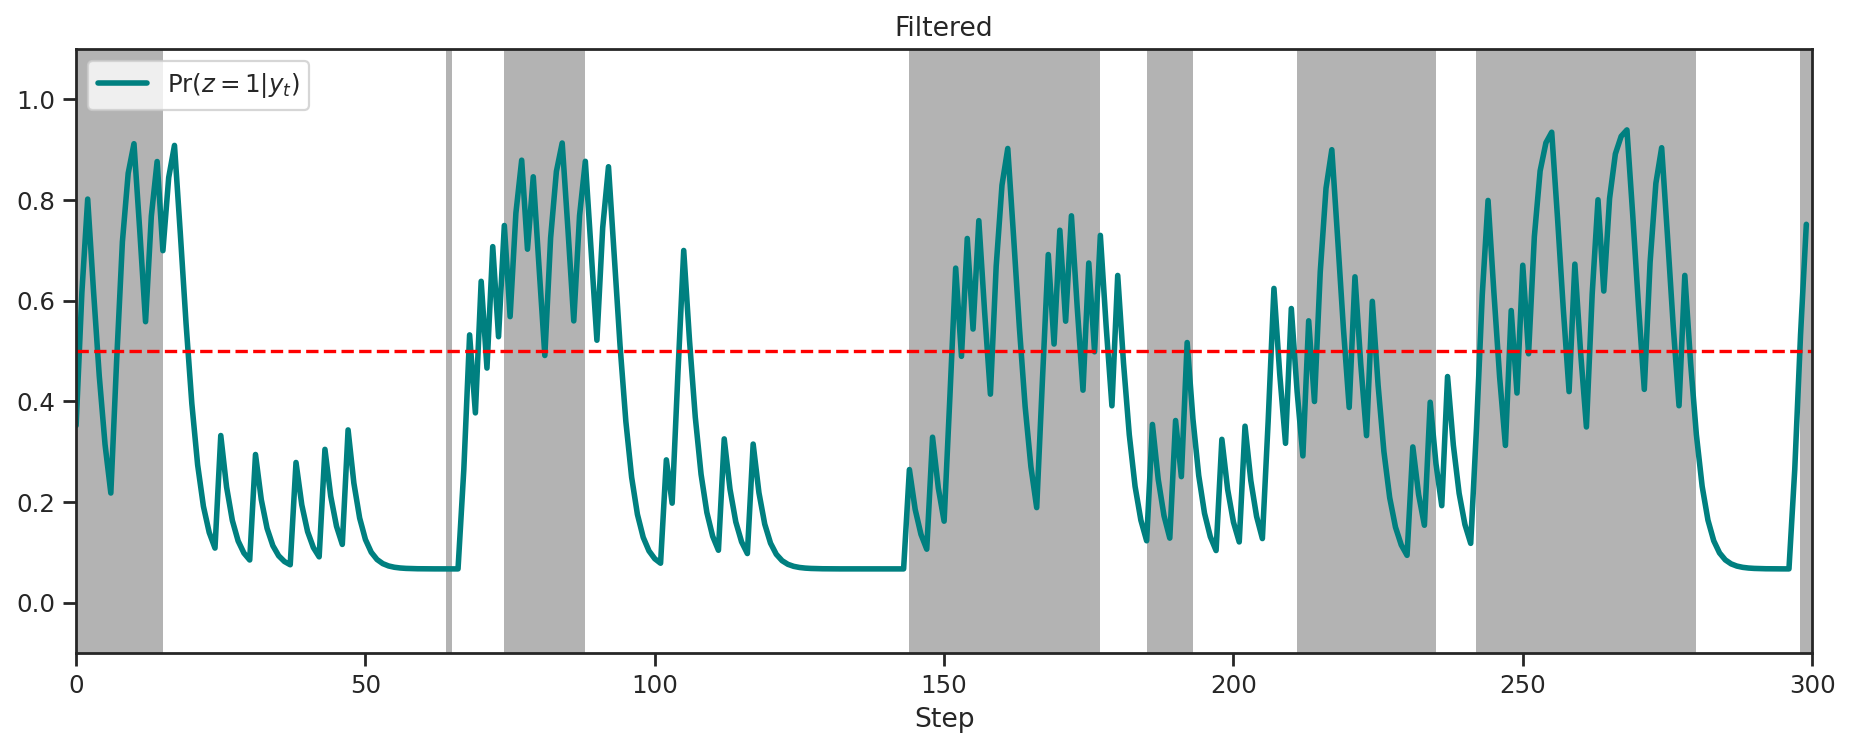

In [30]:
λ_evidence = localEvidence(λ, y)
prob_filtered = Forward(A, states_0, λ_evidence, HMM_steps)
plt.figure(figsize=(14, 5))
plt.imshow(states_true[None, :], extent=(0, HMM_steps, -0.1, 1.1), cmap='Greys', alpha=0.3, aspect='auto')
plt.plot(tf.squeeze(prob_filtered[:,1]), label='$\Pr(z=1|y_t)$', color="teal", linewidth=2.5)
plt.axhline(0.5, color = 'red', linestyle='--')
plt.title("Filtered"); plt.xlabel('Step'); plt.legend(loc='upper left'); plt.ylim(-0.1, 1.1); plt.show()

100%|██████████| 299/299 [00:00<00:00, 1188.59it/s]


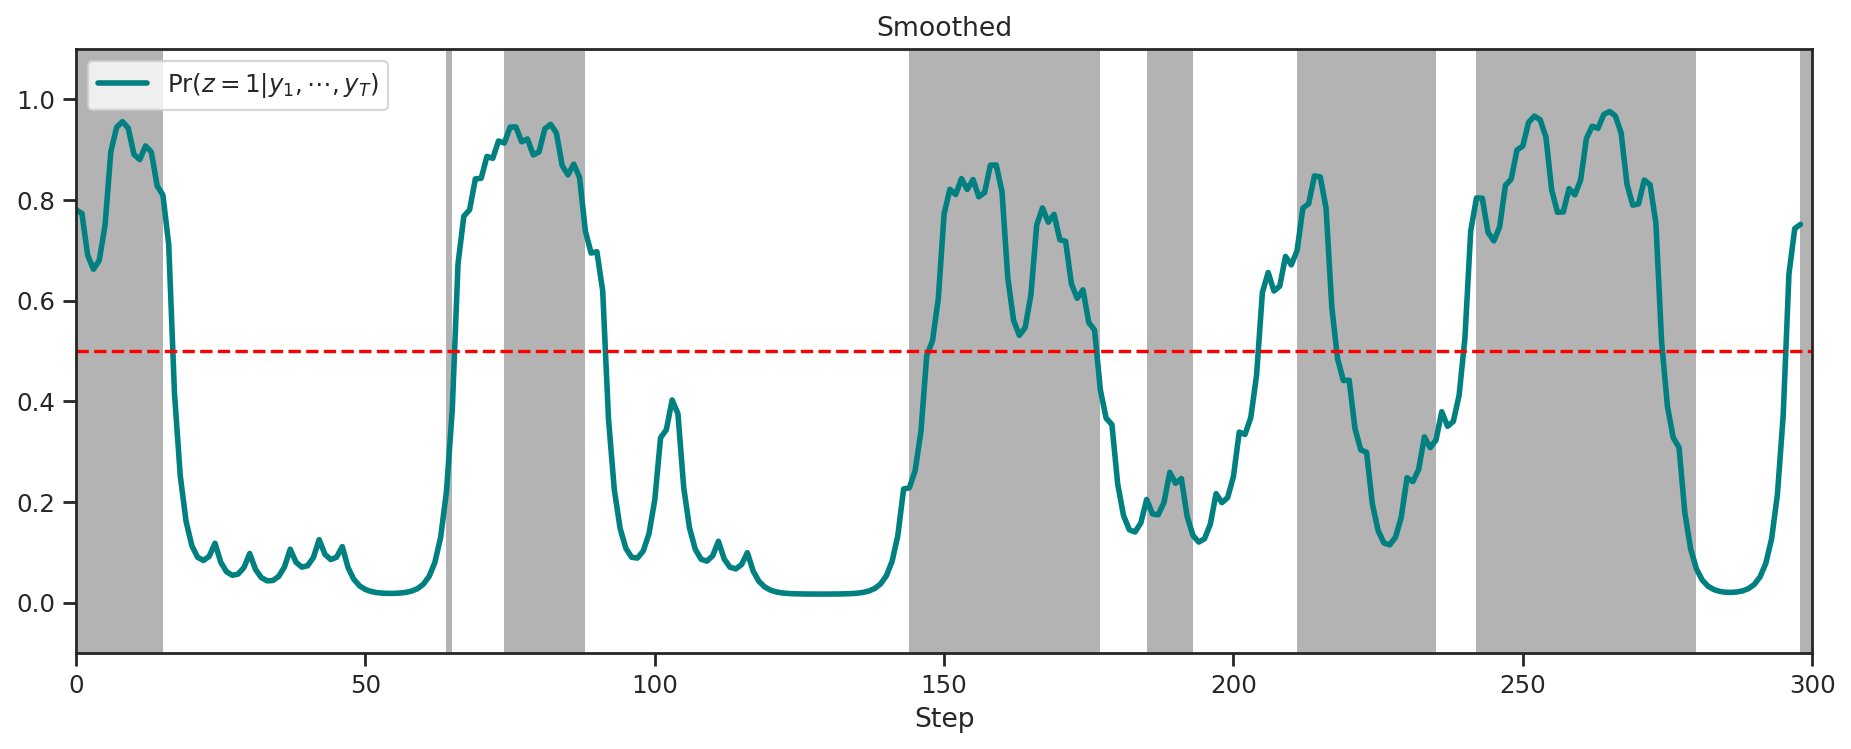

In [31]:
β, prob_smoothed = Backward(A, prob_filtered, λ_evidence, HMM_steps, num_states)
plt.figure(figsize=(14, 5))
plt.imshow(states_true[None, :], extent=(0, HMM_steps, -0.1, 1.1), cmap='Greys', alpha=0.3, aspect='auto')
plt.plot(tf.squeeze(prob_smoothed[:,1]), label='$\Pr(z=1|y_1,\cdots, y_T)$', color="teal", linewidth=2.5)
plt.axhline(0.5, color = 'red', linestyle='--')
plt.title("Smoothed"); plt.xlabel('Step'); plt.legend(loc='upper left'); plt.ylim(-0.1, 1.1); plt.show()

100%|██████████| 299/299 [00:02<00:00, 147.01it/s]


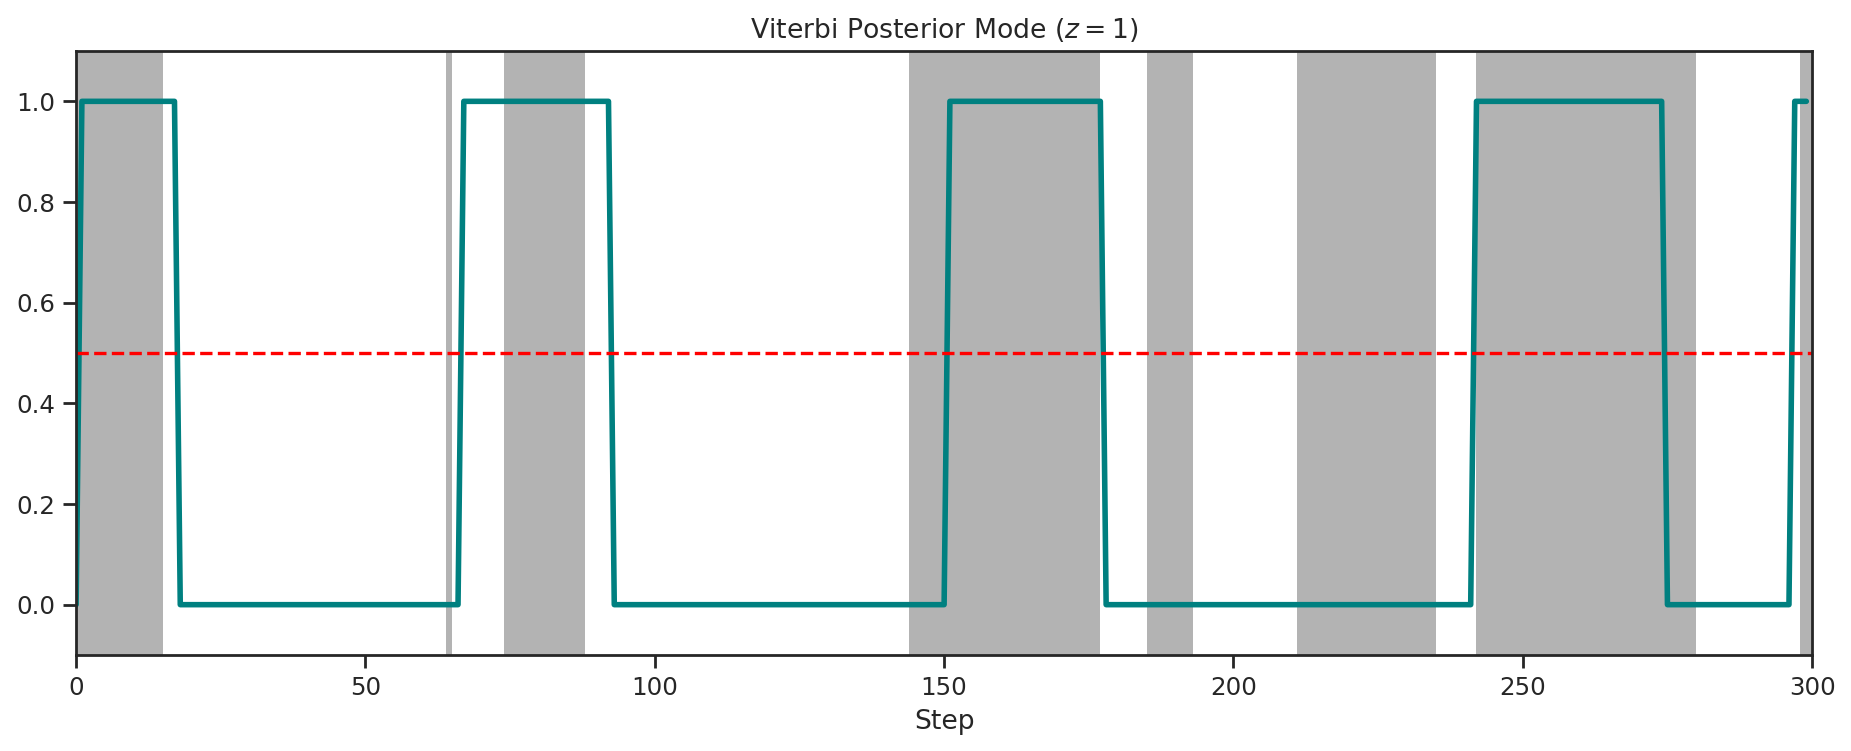

In [32]:
states_Viterbi = Viterbi(A, states_0, λ_evidence, HMM_steps, num_states)
plt.figure(figsize=(14, 5))
plt.imshow(states_true[None, :], extent=(0, HMM_steps, -0.1, 1.1), cmap='Greys', alpha=0.3, aspect='auto')
plt.plot(states_Viterbi, color="teal", linewidth=2.5)
plt.axhline(0.5, color = 'red', linestyle='--')
plt.title("Viterbi Posterior Mode ($z=1$)"); plt.xlabel('Step'); plt.ylim(-0.1, 1.1); plt.show()